**Prospect:** In this notebook contains all descriptive analytics. That means we show the temporal demand patterns and seasonality, geographic demand patterns and derive our KPIs from the areas of utilization, revenue and coverage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date, time
import math
import pickle
import folium
from folium import plugins
from folium.plugins import HeatMap

axis_font = {'size':'20'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

In [2]:
df_LA = pd.read_pickle("../data/LA.pickle")
df_LA_geo = pd.read_pickle("../data/LA_geo.pickle")
weather=pd.read_csv('../data/weather.csv')
weather.date_time = pd.to_datetime(weather.date_time)
weather.set_index('date_time', inplace=True)

# Temporal Demand Patterns and Seasonality

A demonstration of how the fleet varies during a day, a week, the year and for each season.

In [3]:
df_LA['Time'] = pd.to_datetime(df_LA['start_time']).dt.time
df_LA['Day'] = pd.to_datetime(df_LA['start_time']).dt.date
df_LA["Day"]= pd.to_datetime(df_LA["Day"])
df_LA["Weekday"]= pd.to_datetime(df_LA["start_time"]).dt.dayofweek
df_LA["Hour"] = pd.to_datetime(df_LA["start_time"]).dt.hour
df_LA["Month"]= pd.to_datetime(df_LA["start_time"]).dt.month

Text(0, 0.5, 'Bike Trips')

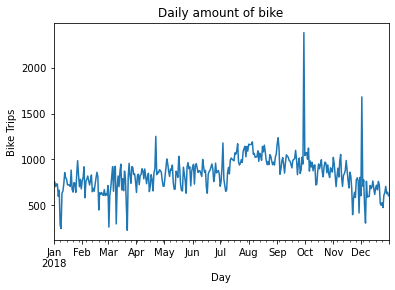

In [4]:
# Count bike trips by Day
bikes_by_day = df_LA.pivot_table("bike_id", aggfunc='count', index="Day" )
ax = bikes_by_day.plot(title ="Daily amount of bike", legend=False)
ax.set_xlabel("Day")
ax.set_ylabel("Bike Trips")

In [5]:
#Weekly
bikes_by_weekday = bikes_by_day.groupby(bikes_by_day.index.dayofweek).mean()
bikes_by_weekday= bikes_by_weekday.rename(index={0: "Mo", 1: "Tu",2: "We",3: "Th",4: "Fr",5: "Sa",6: "Su"})

Text(0.5, 0, 'Weekday')

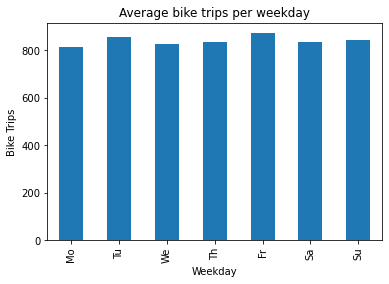

In [6]:
ax= bikes_by_weekday.plot(title ="Average bike trips per weekday", legend=False, kind = "bar")
ax.set_ylabel("Bike Trips")
ax.set_xlabel("Weekday")

The bike trips have their highest demand on the Tuesdays and Fridays. The demand for each day looks uniformly distributed.

Text(0, 0.5, 'Bike Trips')

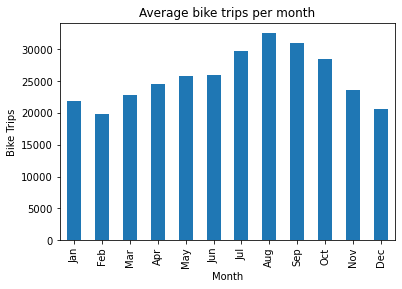

In [7]:
#Calculate average bike trips per Month
bikes_by_month = df_LA.pivot_table("bike_id", aggfunc='count', index="Month" )
bikes_by_month = bikes_by_month.rename(index={1: "Jan", 2: "Feb",3: "Mar",4: "Apr",5: "May",6: "Jun",7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct",11: "Nov", 12: "Dec"})
ax = bikes_by_month.plot(title ="Average bike trips per month", legend=False, kind = "bar")
ax.set_xlabel("Month")
ax.set_ylabel("Bike Trips")

Between July and August the demand for bike trips increase. This could be due to the fact that during these months the weather is very warm.

Text(0, 0.5, 'Bike Trips')

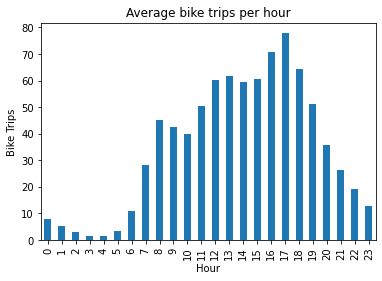

In [8]:
#Calculate average bike trips per Hour
bikes_by_hours = df_LA.groupby(['Hour'])['bike_id'].count().div(365)
ax = bikes_by_hours.plot(title ="Average bike trips per hour", legend=False, kind = "bar")
ax.set_xlabel("Hour")
ax.set_ylabel("Bike Trips")

The demand for bike renting increase between 11 a.m. till 5 p.m.. Bikes can be used as a form of transportation for the way to work, for lunch, or to go home.

Text(0.5, 0, 'Seasons')

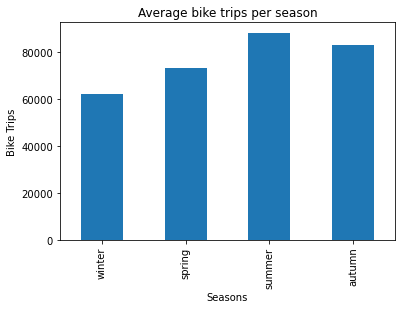

In [9]:
#Calculate average bike trips per Season
x = df_LA.copy()
x["season"] = x.Day.dt.month%12 // 3 + 1
season_time = x.pivot_table("bike_id", aggfunc ='count', index = "season" )
season_time = season_time.rename(index={ 1: "winter",2: "spring", 3: "summer", 4:"autumn"})
ax = season_time.plot(title ="Average bike trips per season", legend=False, kind ="bar")
ax.set_ylabel("Bike Trips")
ax.set_xlabel("Seasons")

Season 'summer' has the highest number of average bike trips.

# Geographical Demand Patterns

A presentation of which stations are particularly popular/unpopular and rational explanations of these patterns.

**Read in df_LA_stations**<br>
Here we use the geographical center to define the center for the following maps. The dataframe df_LA_stations contains all station names, the IDs and the geographical data

In [10]:
#define LA center
center = np.array(['34.053691', '-118.242766'])

#read in LA_stations
df_LA_stations = pd.read_pickle("../data/LA_stations.pickle")  
df_LA_stations.head(2)

station_id       lat         lon  station_name  7/7/2016   N/A  Active  \
0        3005  34.04850 -118.258537  7th & Flower  7/7/2016  DTLA  Active   
1        3006  34.04554 -118.256668   Olive & 8th  7/7/2016  DTLA  Active   

                     coord  
0   [34.0485, -118.258537]  
1  [34.04554, -118.256668]

**Create df_trips**<br>
The dataframe contains all the trips and the geographical informatioon for the bike stations

In [11]:
#add origin and destination column to df_trips
df_trips = df_LA_geo
df_trips = df_trips.dropna()

#round
df_trips = df_trips.round({'start_lat': 6, 'start_lon': 6, 'end_lat': 6, 'end_lon': 6})

df_trips = df_trips.assign(orig=df_trips.apply(lambda x: [x['start_lat'],x['start_lon']],axis=1))
df_trips = df_trips.assign(dest=df_trips.apply(lambda x: [x['end_lat'],x['end_lon']],axis=1))
df_trips.head(2)

start_time            end_time  start_station_id  end_station_id  \
0 2018-01-01 00:04:00 2018-01-01 00:25:00              3063            3018   
1 2018-01-01 00:05:00 2018-01-01 00:25:00              3063            3018   

   bike_id user_type start_station_name end_station_name   trip_duration  \
0     5889   Walk-up    Pershing Square  Grand & Olympic 0 days 00:21:00   
1     6311   Walk-up    Pershing Square  Grand & Olympic 0 days 00:20:00   

   trip_duration_in_hours  start_lat   start_lon    end_lat     end_lon  \
0                0.350000  34.048326 -118.253513  34.043732 -118.260139   
1                0.333333  34.048326 -118.253513  34.043732 -118.260139   

                       orig                      dest  
0  [34.048326, -118.253513]  [34.043732, -118.260139]  
1  [34.048326, -118.253513]  [34.043732, -118.260139]

**Map of all bike stations**

The following map shows all the bike stations of the given dataset. 
<br> We created a station list in the preprocess which contains all the stations used in 2018.

In [12]:
print('The station list contains ' + str(len(df_LA_stations)) + ' stations.')

The station list contains 131 stations.


In [13]:
def bikestation_map(location, df_stations):
    bikestation_map = folium.Map(
        location=location, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add station point map
    for index, row in df_stations.iterrows():
        folium.CircleMarker(
            radius=5,
            location=row['coord'],
            popup=row['station_name'], 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson'
        ).add_to(bikestation_map)
    return bikestation_map
map1 = bikestation_map(center, df_LA_stations)
map1

The stations can be divided into four areas:<br>
>-Los Angeles Center<br>
>-Santa Monica<br>
>-Pasadene<br>
>-San Pedro

**Frequently used stations**

The next map shows the most frequently used stations in LA. Here we draw a bigger Circle for a more frequently used station.

In [14]:
#get info about the most frequently used bike stations
df_LA_stations
df_joined = pd.DataFrame()

#count the appereance of the stations
df_start_station = pd.DataFrame(df_LA_geo.groupby('start_station_id')['start_station_name'].count())
df_start_station = df_start_station.rename(columns={'start_station_name': 'start_station_count'})
df_end_station=pd.DataFrame(df_LA_geo.groupby('end_station_id')['end_station_id'].count())
df_end_station = df_end_station.rename(columns={'end_station_id': 'end_station_count'})
df_both_station = pd.DataFrame(df_LA_geo[df_LA_geo['start_station_id']==df_LA_geo['end_station_id']].groupby('end_station_id')['end_station_id'].count())
df_both_station = df_both_station.rename(columns={'end_station_id': 'both_station_count'})

#sum the counted values
df_joined = df_start_station.join(df_end_station, lsuffix='start_station_id', rsuffix='end_station_id')
df_joined = df_joined.join(df_both_station, lsuffix='start_station_id', rsuffix='start_station_id')
df_joined = df_joined.assign(total_count=df_joined['start_station_count']+df_joined['end_station_count']-df_joined['both_station_count'])

#sort by total count, add normalized column and transform df
df_joined = df_joined.sort_values(by='total_count', ascending = False)
df_joined = df_joined.reset_index().rename(columns={'start_station_id':'station_id'})
df_joined = df_joined.assign(normalized_count = df_joined.apply(lambda x: x['total_count'] / df_joined.loc[0]['total_count'], axis=1))

#join the geo data and drop rows without geo data
df_joined = df_joined.join(df_LA_stations, lsuffix='station_id', rsuffix='id').dropna()

df_joined.head(2)


#draw the map with circle rasius
def circle_radius_map():
    bikestation_map = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add station point map
    for index, row in df_joined.iterrows():
        folium.CircleMarker(
            radius=10*row['normalized_count'],
            location=row['coord'],
            popup=row['station_name'], 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson'
        ).add_to(bikestation_map)
    return bikestation_map
map2 = circle_radius_map()
map2

We can see that the most frequently used stations tend to be located in the center. 
An exception is the Anaheim & Avalon station, which is located in the residential area of the southern coast.

**Trip Movement of most frequently used station (7th & Flower: 3005)**

The following map shows random 1000 trips from the most frequently used bike station "7th & Flower". We limited the number to 1000 for a better runtime. Of course it ist possible to show all trips. Each blue circle symbolizes the start and each red circle the end of a trip.

In [15]:
def trips_map(origins_list, origin_namelist, destinations_list, destination_namelist): 
    # define new map
    trips_map = folium.Map(
        location=center,  
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20,
        height=1000)

    #draw trips
    for orig, orign, dest, destn in zip(origins_list, origin_namelist, destinations_list, destination_namelist):
        # Origin point
        #print(orig)
        folium.CircleMarker(
            radius=5,
            location=orig,
            popup=orign, 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson').add_to(trips_map)
        # Destination point
        #print(dest)
        folium.CircleMarker(
            radius=5,
            location=dest,
            popup=destn, 
            color='blue', 
            alpha=0.2,
            fill_color='blue').add_to(trips_map)
        # Trip movement
        folium.PolyLine(
            (orig, dest),
            color="gray", 
            weight=1, 
            opacity=1).add_to(trips_map)
    return trips_map

#random 1000 trips from ONE STATION
df_trips_sliced = df_trips[(df_trips['start_station_id'] == 3005) | (df_trips['end_station_id'] == 3005)]
df_trips_sliced = df_trips_sliced.sample(n=1000)

#columns as list
orig_list = df_trips_sliced['orig'].tolist()
orig_name = df_trips_sliced['start_station_name'].tolist()
dest_list = df_trips_sliced['dest'].tolist()
dest_name = df_trips_sliced['end_station_name'].tolist()

#warning when you want to print to many trips
if(len(df_trips_sliced) > 1000):
    print('Runtime warning: You are going to print ' + str(len(df_trips_sliced))+ ' trips. Recommended are trips < 1000.')
    tmap = np.nan
else:
    print('Printing...')
    #trip map
    tmap = trips_map(orig_list,orig_name, dest_list, dest_name)
map3 = tmap
map3

Printing...


The map above shows that most trips that start (blue circle) at the frequently used station 7th & Flower also end (red circle) in downtown Los Angeles. 
There are only a few that go to the west coast to Sanata Monica.

# Key Performance Indicators (KPIs)

We have developed KPIs in the three areas of utilization, revenue and coverage.

## Utilization

### Maximum Utilitation: Utilization Based on Trips per Hour

We use trips taken per hour divided by bike fleet size of the transporation agency Metro as a KPI to estimate the fleet's utilization. We thereby count all trips occouring in the span of an hour, including trips that start in the respective hour as well as trips that are ongiong. The KPI calculates the percentage of the bike fleet utilized if all where taken with distinct bikes. It tells us how many bikes would be needed at most to supply the observed demand.

In [16]:
#data frame: count starts and ends of trips
trips_started = df_LA.start_time.value_counts()
trips_ended = df_LA.end_time.value_counts()
trip_count =  pd.concat([trips_started, trips_ended],axis = 1)
trip_count.rename(columns = {'start_time':'trips_started','end_time':'trips_ended'}, inplace = True)
trip_count.fillna(0, inplace = True)
    
#add trips starting/ending since the last entry, amount of trips occouring at one time
trip_count['difference_to_last_entry'] = trip_count.trips_started - trip_count.trips_ended
trip_count['trips_occuring'] = trip_count.trips_started.cumsum() - trip_count.trips_ended.cumsum()
trip_count

trips_started  trips_ended  difference_to_last_entry  \
2018-01-01 00:04:00            1.0          0.0                       1.0   
2018-01-01 00:05:00            1.0          0.0                       1.0   
2018-01-01 00:06:00            1.0          0.0                       1.0   
2018-01-01 00:13:00            1.0          0.0                       1.0   
2018-01-01 00:14:00            2.0          0.0                       2.0   
...                            ...          ...                       ...   
2018-12-31 23:46:00            1.0          0.0                       1.0   
2018-12-31 23:47:00            1.0          0.0                       1.0   
2018-12-31 23:54:00            0.0          5.0                      -5.0   
2018-12-31 23:55:00            0.0          1.0                      -1.0   
2018-12-31 23:56:00            0.0          2.0                      -2.0   

                     trips_occuring  
2018-01-01 00:04:00             1.0  
2018-01-01 00:05:00             2.0  
2018-01-01 00:06:00             3.0  
2018-01-01 00:13:00             4.0  
2018-01-01 00:14:00             6.0  
...                             ...  
2018-12-31 23:46:00             7.0  
2018-12-31 23:47:00             8.0  
2018-12-31 23:54:00             3.0  
2018-12-31 23:55:00             2.0  
2018-12-31 23:56:00             0.0  

[278862 rows x 4 columns]

The indicator trips per hour is calcluated as the sum of trips starting in the respective hour and the trips that started in a previous hour and are still occour in the respective hour.

In [17]:
trips_ongoing = trip_count.trips_occuring.resample('H').first().fillna(method ='ffill') 
- trip_count.difference_to_last_entry.resample('H').first().fillna(0)
trips_new = trip_count.trips_started.resample('H').sum().fillna(0)
trips_per_hour = trips_ongoing + trips_new
trips_per_hour

2018-01-01 00:00:00    26.0
2018-01-01 01:00:00    34.0
2018-01-01 02:00:00    23.0
2018-01-01 03:00:00     5.0
2018-01-01 04:00:00     6.0
                       ... 
2018-12-31 19:00:00    31.0
2018-12-31 20:00:00    20.0
2018-12-31 21:00:00    34.0
2018-12-31 22:00:00    28.0
2018-12-31 23:00:00    17.0
Freq: H, Length: 8760, dtype: float64

The KPI of maximum utilization is calculated as trips taken in an hour devided by the number of distinct bikes in the fleet. It indicated the pecentage of the bike fleet utilized, if all trips occouring in an hour are taken with a different bike. 

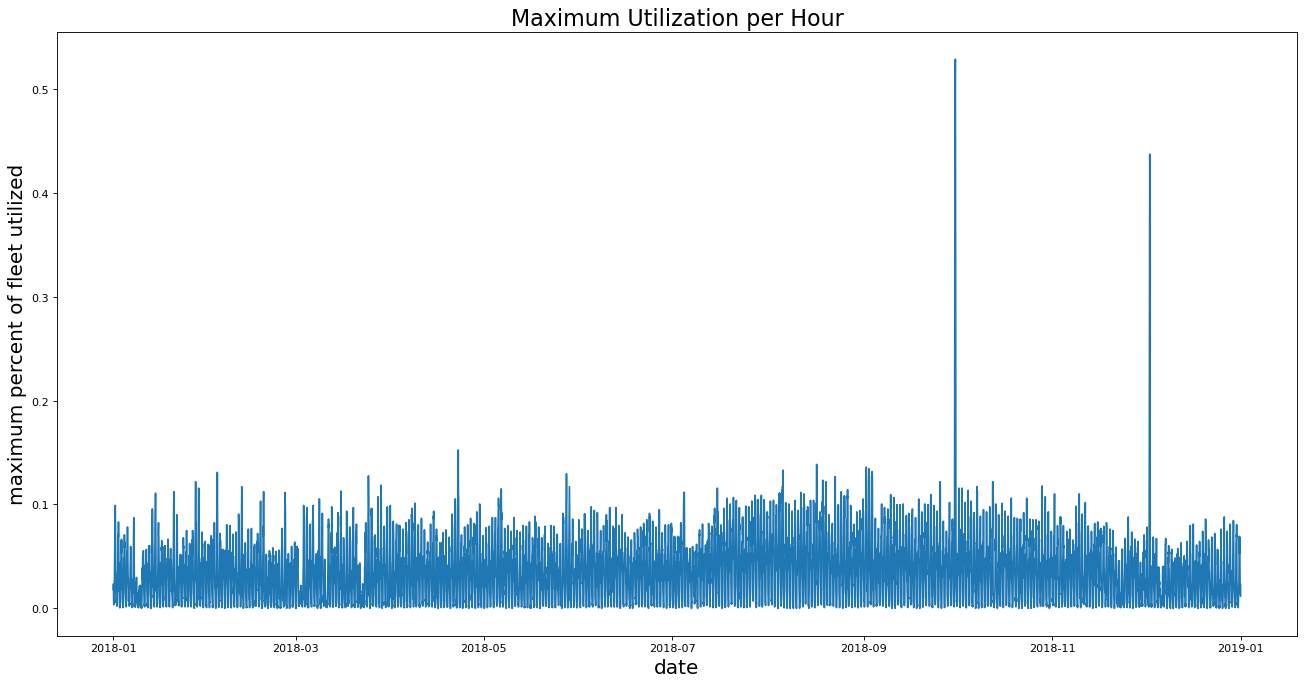

In [18]:
max_utilization = pd.DataFrame(trips_per_hour/ df_LA["bike_id"].nunique(), columns = ['max_utilization'])

fig,ax = plt.subplots(figsize=(20,10), dpi= 80) 
axis_font = {'size':'18'}
dic={'fontsize': '20'}

ax.plot(max_utilization, color = 'tab:blue')
ax.set_title("Maximum Utilization per Hour", dic)
ax.set_ylabel('maximum percent of fleet utilized',**axis_font)
ax.set_xlabel('date',**axis_font)
plt.show()

Bicycle utilization peaks on September 30 with over 50 percent utilization and December 2 with over 40 percent utilization.<br> September 30, 2018 was the day of the "CicLAvia x LA Phil 100". The "CicLAvia Heart of LA" was held on December 2.<br> Both are events organized by CicLAvia where streets are cleared into car-free zones for recreational use.

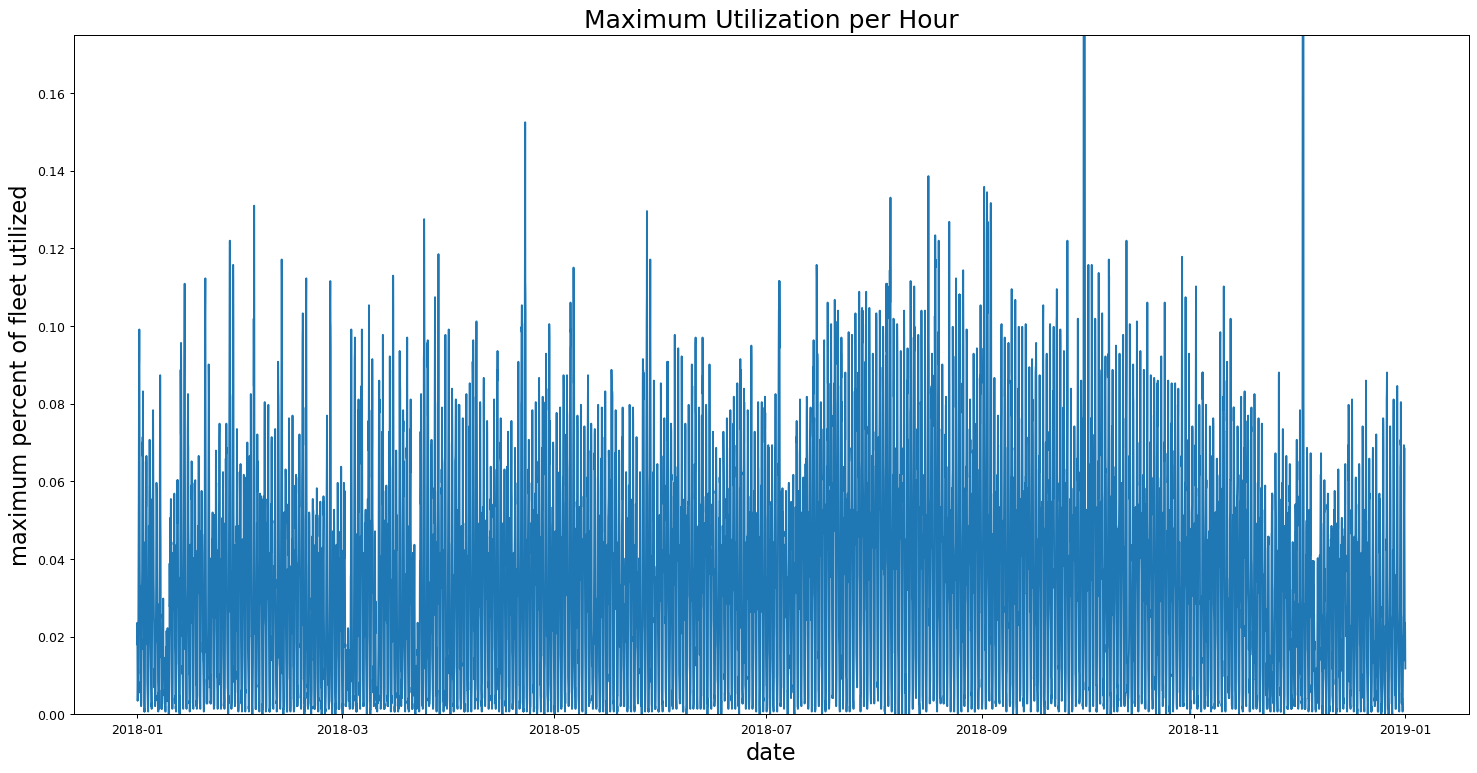

In [19]:
fig,ax = plt.subplots(figsize=(20,10), dpi= 90) 

ax.plot(max_utilization, color = 'tab:blue')
ax.set_title("Maximum Utilization per Hour", dic)
ax.set_ylabel('maximum percent of fleet utilized',**axis_font)
ax.set_xlabel('date',**axis_font)
ax.set_ylim([0,0.175])
plt.show()

The KPI maximum utilization is relative low all year long. Apart from the days of the two bike events events, no utilization of more than 16 percent is achieved. <br>
Between January and April, the bike utilization is rather inconsistent. This could be related to rain or low temperature in the beginning of the year. Between May and June the utilization becomes more consistent. The average bike utilization is highest between July and September. There is a drop in utilization in July. This could be related to high temperatures at this time of year. From October on, the average utilization decreases again.


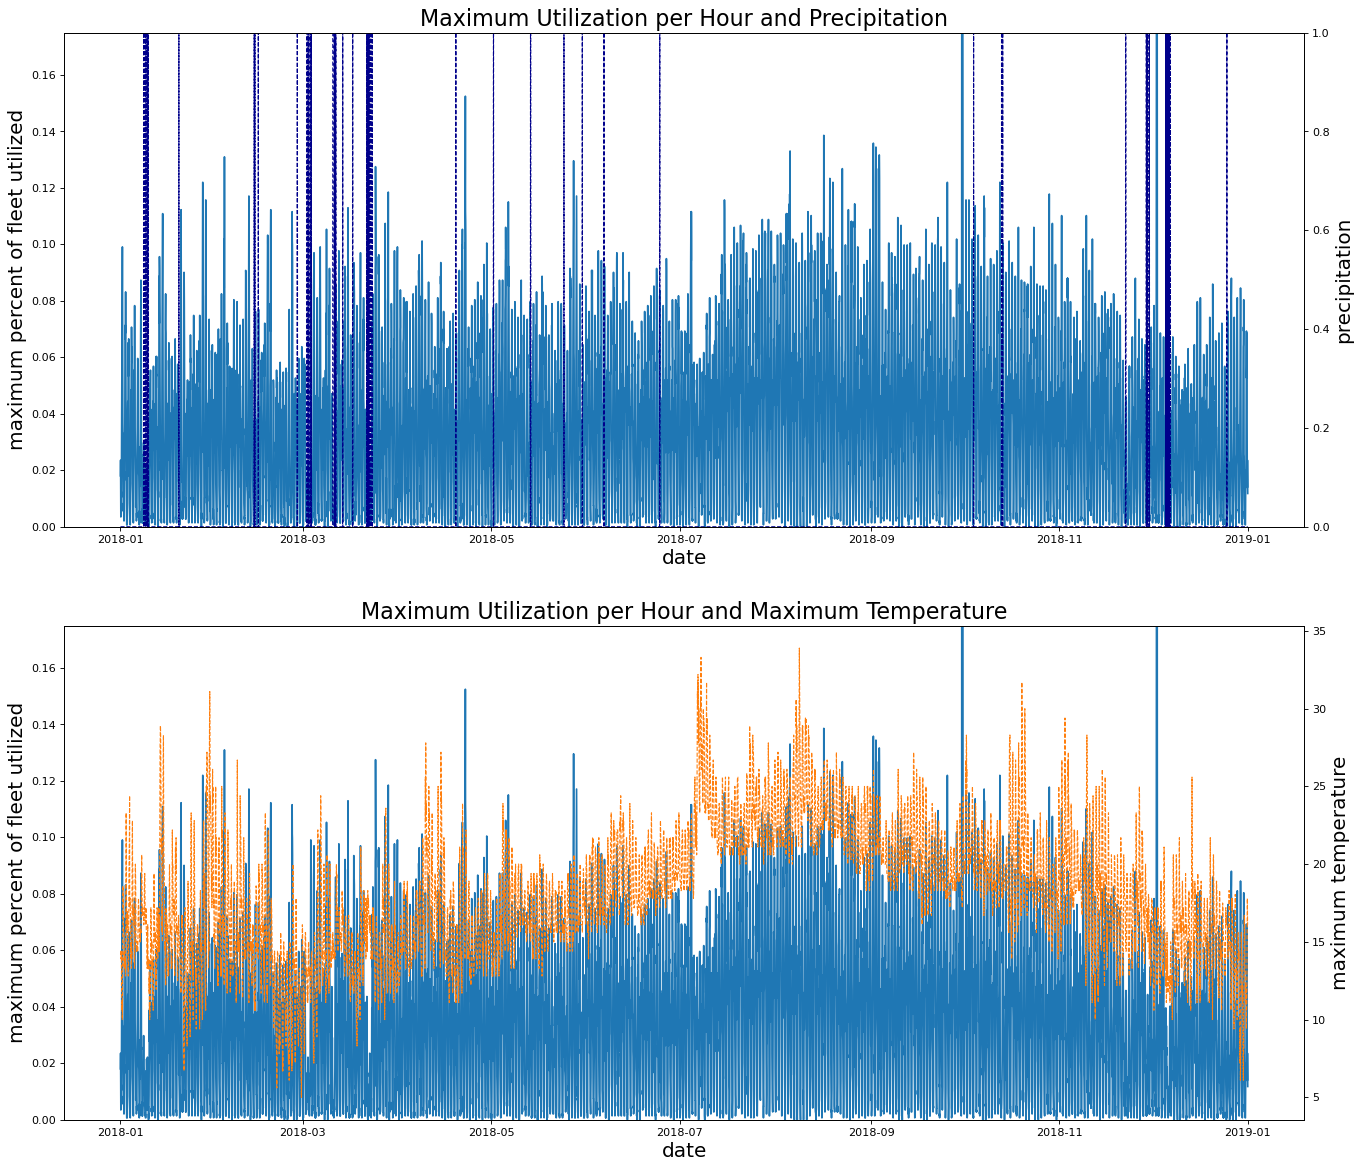

In [20]:
fig,ax1 = plt.subplots(2, 1, figsize=(20,18), dpi= 80) 
ax2 = ax1[0].twinx()

ax1[0].plot(max_utilization, color = 'tab:blue')
ax1[0].set_title("Maximum Utilization per Hour and Precipitation", dic)
ax1[0].set_ylabel('maximum percent of fleet utilized',**axis_font)
ax1[0].set_xlabel('date',**axis_font)
ax1[0].set_ylim([0,0.175])

ax2.plot(weather.precip, color = 'darkblue',linestyle = '--',linewidth=1)
ax2.set_ylabel('precipitation',**axis_font)
ax2.set_ylim([0,1])


ax2 = ax1[1].twinx()

ax1[1].plot(max_utilization, color = 'tab:blue')
ax1[1].set_title("Maximum Utilization per Hour and Maximum Temperature", dic)
ax1[1].set_ylabel('maximum percent of fleet utilized',**axis_font)
ax1[1].set_xlabel('date',**axis_font)
ax1[1].set_ylim([0,0.175])

ax2.plot(weather.max_temp, color = 'tab:orange',linestyle = '--', linewidth=1)
ax2.set_ylabel('maximum temperature',**axis_font)

plt.show()

The KPI in relation to weather shows that rain is associated with lower utilization.<br> As previously suspected, the temperatures at the time of the utilization drop in July were higher than at any time in the year. Temperatures reached up to 33 degrees. Also, on days with low temperature, the utilization is lower.

### Distinct Used Bikes

This KPI shows the total number of hourly activated and ended bikes. First, we want to show the distribution hourly over the year. To do so we create a dataframe for the started trips and a second dataframe for the ended trips. Then we simply add those together to get the total amount.

In [21]:
# df transformation
df_start_time=df_LA.set_index("start_time")
df_end_time=df_LA.set_index("end_time")
df_start_time = df_start_time['bike_id'].resample("H").nunique()
df_end_time = df_end_time['bike_id'].resample("H").nunique()

In [22]:
# We can here simply add the start_times and the end_times dataframe, because they have the same amount of rows:
print(df_end_time.count())
print(df_start_time.count())

8760
8760


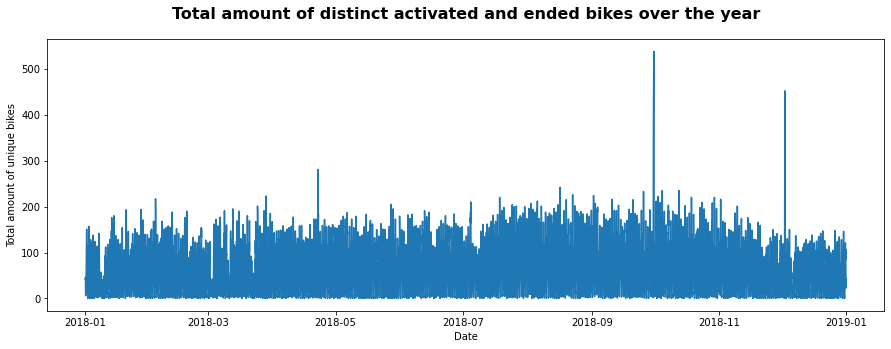

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Total amount of distinct activated and ended bikes over the year", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Date")
ax.set_ylabel("Total amount of unique bikes")

# calculation of total amount of distinct bikes
ax.plot(df_start_time + df_end_time)
plt.show()

This calculation correlates to the utilization, which we have described before. There are two outliers, who show an outstanding high utilization rate, because of the car-free events. The rest of the year can also be described analogue to the utilization rate.

Now we want to show the hourly distribution over a day. We therefore split the available date times of end and start into hour and date (yyyy.mm.dd)

In [24]:
df_LA['start_hour'] = df_LA['start_time'].dt.hour
df_LA['start_day'] = df_LA['start_time'].dt.date

df_LA['end_hour'] = df_LA['end_time'].dt.hour
df_LA['end_day'] = df_LA['end_time'].dt.date

Text(0, 0.5, 'Amount of unique bikes')

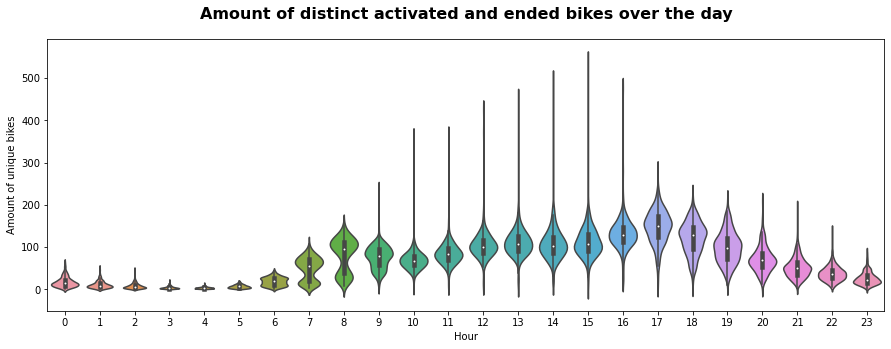

In [25]:
act_bikes = df_LA.groupby(['start_day', 'start_hour'])['bike_id'].nunique().reset_index()
end_bikes = df_LA.groupby(['end_day', 'end_hour'])['bike_id'].nunique().reset_index()

merged = act_bikes.merge(end_bikes, left_on=['start_day', 'start_hour'], right_on=['end_day', 'end_hour'], how='inner')
merged['anzahl'] = merged.bike_id_x + merged.bike_id_y

result = merged.drop(['bike_id_x', 'bike_id_y', 'end_day', 'end_hour'], axis=1)

fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(
    x=result['start_hour'],
    y=result['anzahl'],
    scale="count")

ax.set_title("Amount of distinct activated and ended bikes over the day", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Hour")
ax.set_ylabel("Amount of unique bikes")

Let's first have a look at the box plots in the middle of the violinplot, with the median shown as the white dot. We can see that between 12 and 5 a.m. during night there is very low mean utilization. In the morning at about 6 a.m. the utilization begins to rise, with peak at 8 a.m.. This could be due to people using the bikes for getting to work. From 9 a.m. till 4 p.m. the average utilization stays approximately the same. At 5 p.m. there again is a peak, which probably is due to rush hour at the evening. After that it constantly drops again. The distribution shape fo the data is shown by the curves of the right and left side of the plots. They emphasis the high workload at 8 and 17, where most of the datapoints are located.
By looking at the thin gray line in the center, we can see that especially in the morning, beginning from 10 a.m. until 3 p.m., the maximum workload is received. However, the distribution around there is very low, so this peaks are achieved only at very few days in the year - certainly due to the car free events, which took place on September 30th and December 2nd. They took place in exactly that time span (10 a.m. - 3 p.m.).

### Average Waiting Time

This KPI calculates the average time between the end of a trip and the start of the next trip.

In [26]:
#initial df transformations
df_waiting = df_LA
df_waiting = df_waiting.sort_values(by=['bike_id','end_time'], ascending=True)
df_waiting = df_waiting[['start_time','end_time', 'bike_id','end_station_id']]

#add columns next_ride_start and next_bike_id which contain the shifted columns
df_waiting = df_waiting.assign(next_ride_start=0)
df_waiting['next_ride_start']= df_waiting['start_time'].shift(periods=-1)
df_waiting = df_waiting.assign(next_bike_id=0)
df_waiting['next_bike_id']= df_waiting['bike_id'].shift(periods=-1)
df_waiting = df_waiting.drop(columns={'start_time'})

#add column which contains a bool value to sign if the next entry is still about the same bike (condition for comparison)
df_waiting['id_compare'] = df_waiting.apply(lambda x: True if ((x['bike_id'] == x['next_bike_id'])) else False, axis=1)
df_waiting = df_waiting.dropna() #drop last row because of nan

#filter: only entrys with id_compare == True
df_waiting = df_waiting[df_waiting['id_compare']== True]

#calc the unused time only when id_compare == True (-->same bike is used in next trip)
df_waiting['waiting_time'] = df_waiting.apply(lambda x: x['next_ride_start'] - x['end_time'], axis=1)

df_waiting.head(2)

end_time  bike_id  end_station_id     next_ride_start  \
299 2018-01-01 12:58:00     4727            3031 2018-01-01 14:12:00   
422 2018-01-01 14:13:00     4727            3031 2018-01-05 10:33:00   

     next_bike_id  id_compare    waiting_time  
299        4727.0        True 0 days 01:14:00  
422        4727.0        True 3 days 20:20:00

**Average waiting time for each bike (Top 5 highest waiting times)**

Here we can see the five longest waiting times and the corresponding bikes.

In [27]:
#group by: Average waiting time for bike 
df_avg_waiting = df_waiting.groupby(by='bike_id').agg({'waiting_time': pd.Series.mean})
df_avg_waiting = df_avg_waiting.reset_index()

#round to seconds
df_avg_waiting['waiting_time'] = df_avg_waiting['waiting_time'].dt.round(freq='s')

#bikes with longest average waiting time
df_avg_waiting.sort_values(by='waiting_time', ascending = False).head(5)

bike_id     waiting_time
486      6225 36 days 01:40:20
867      6628 18 days 04:58:04
1348    12374 17 days 20:00:26
159      5876 17 days 15:41:17
147      5864 17 days 12:02:15

**Average hourly waiting time**

In the next step we visualized the average waiting times *(a) hourly over a day* and *(b) hourly over the year*.

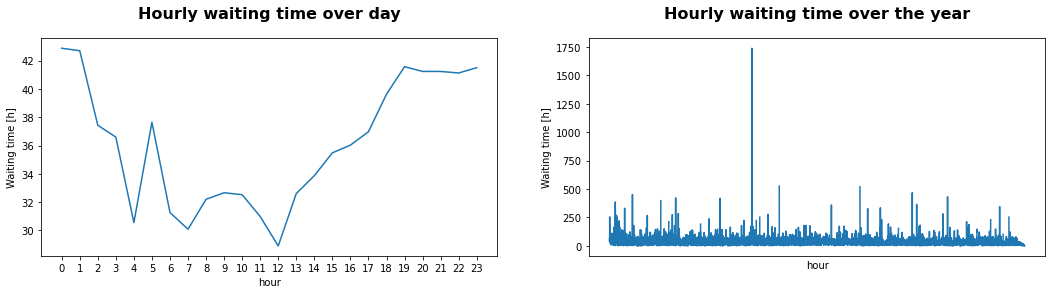

In [28]:
#group by: Average waiting time for bike 
df_hou_waiting = df_waiting
df_hou_waiting = df_hou_waiting.sort_values(by='end_time')

#add hour column to df
df_hou_waiting = df_hou_waiting.assign(hour=df_hou_waiting['end_time'].dt.hour)

#group by hour
df_hou_waiting_grouped_hour = df_hou_waiting.groupby(by='hour').agg({'waiting_time': pd.Series.mean})
df_hou_waiting_grouped_year = df_hou_waiting.groupby(pd.Grouper(key='end_time',freq='1h')).agg({'waiting_time': pd.Series.mean})

#round to seconds
df_hou_waiting_grouped_hour['waiting_time'] = df_hou_waiting_grouped_hour['waiting_time'].dt.round(freq='s')
df_hou_waiting_grouped_year['waiting_time'] = df_hou_waiting_grouped_year['waiting_time'].dt.round(freq='s')

#waiting time in hours
df_hou_waiting_grouped_hour = df_hou_waiting_grouped_hour['waiting_time'] / pd.Timedelta(hours=1)
df_hou_waiting_grouped_year = df_hou_waiting_grouped_year['waiting_time'] / pd.Timedelta(hours=1)

#plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18, 4))
ax[0].set_title("Hourly waiting time over day", fontsize=16, fontweight="bold", pad=20)
ax[0].set_xlabel("hour")
ax[0].set_xticks(np.arange(len(df_hou_waiting_grouped_hour)))
ax[0].set_ylabel("Waiting time [h]")
ax[0].plot(df_hou_waiting_grouped_hour)

ax[1].set_title("Hourly waiting time over the year", fontsize=16, fontweight="bold", pad=20)
ax[1].set_xlabel("hour")
ax[1].set_xticks(np.arange(len(df_hou_waiting_grouped_year)))
ax[1].set_ylabel("Waiting time [h]")
ax[1].plot(df_hou_waiting_grouped_year)
plt.show()

If we look at the average of all days, we see slightly lower waiting times of a bicycle (i.e. the time between the last and the next loan) in the early morning, the morning and around midday. <br> Over the year the average waiting time fluctuates around an average value of approx. 36 hours. 

In [29]:
df_hou_waiting_grouped_year.mean()

36.17620779655679

In [30]:
df_hou_waiting[(df_hou_waiting.end_time >= '2018-05-06 04:00:00')&(df_hou_waiting.end_time < '2018-05-06 05:00:00')]

end_time  bike_id  end_station_id     next_ride_start  \
94698 2018-05-06 04:44:00     6603            3054 2018-07-17 15:02:00   

       next_bike_id  id_compare     waiting_time  hour  
94698        6603.0        True 72 days 10:18:00     4

However, some outliers can be observed, which 
are caused by the number of bicycles borrowed during this hour. For example, the loan of a single bicycle 
between 4 and 5 a.m. on May 6 generated an average value of over 1700 hours.

## Revenue

To finde a good Revenue-KPI we have to investigate a little bit how the pricing system works. At first we have a look at how many rides were done by each user type:

In [31]:
df_LA.groupby("user_type").count()["start_time"].sort_values()

user_type
Annual Pass       2049
Flex Pass         6739
One Day Pass     16956
Walk-up         120345
Monthly Pass    160774
Name: start_time, dtype: int64

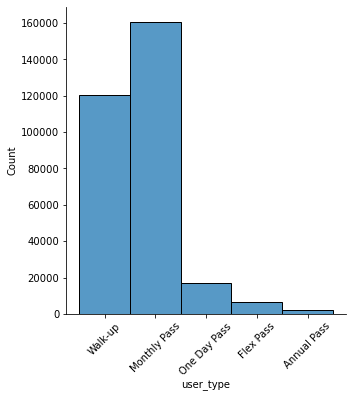

In [32]:
sns.displot(df_LA["user_type"]).set_xticklabels(rotation=45)

### The pricing system

Below the prices are listed which are in place at the moment (december 2021): https://t1p.de/xop9n<br>
The same prices have been in place since August of 2018: https://t1p.de/6cep

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>365-Day Pass</td>
    <td>\$150/year & \$1,75 after 30min</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>30-Day Pass </td>
    <td>\$17/month & \$1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>24-Hour Access</td>
    <td>\$5/day & \$1.75 after 30min</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>\$1.75 per 30min</td>
  </tr>
</table>


In June 2016 the following princing system was in place: https://t1p.de/spq7

<table style="float: left">
  <tr>
    <th>"user_type" in dataset</th>
    <th>name on website</th>
    <th>pricing</th>
  </tr>
  <tr>
    <td>Annual Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Flex Pass</td>
      <td>Flex Pass</td>
    <td>\$40/year & \$1.75 after 30min</td>
  </tr>
  <tr>
    <td>Monthly Pass</td>
    <td>Monthly Pass </td>
    <td>\$20/month & \$1.75 after 30min</td>
  </tr>
  <tr>
    <td>One Day Pass</td>
    <td>(does not exist)</td>
    <td>/</td>
  </tr>
  <tr>
    <td>Walk-Up</td>
    <td>1-Ride</td>
    <td>\$3.50 per \$30min</td>
  </tr>
</table>

Prices have changed within 2018. Unfortunately, there is no information on the internet about what the prices were at the beginning of 2018. <br>
We now take a look at how often rides were started by the different user_types:

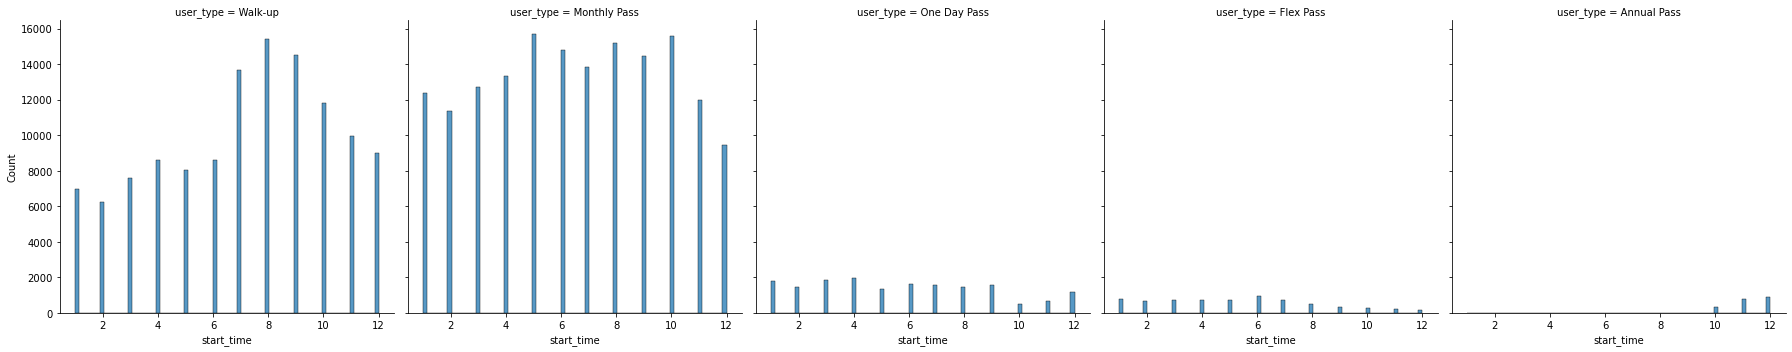

In [33]:
df_temp = df_LA.copy()
df_temp["start_time"] = df_temp["start_time"].dt.month
sns.displot(df_temp, x="start_time", col="user_type")

Having a closer look at the Annual Pass, because there were no rides in the first 8 months.

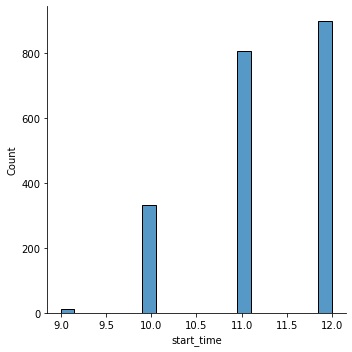

In [34]:
sns.displot(df_temp[df_temp["user_type"] == "Annual Pass"], x="start_time")

In [35]:
df_LA[df_LA["user_type"] == "Annual Pass"]["start_time"].describe(datetime_is_numeric=True)

count                             2049
mean     2018-11-24 10:45:31.039531264
min                2018-09-29 13:52:00
25%                2018-11-08 15:06:00
50%                2018-11-27 09:46:00
75%                2018-12-13 09:05:00
max                2018-12-31 22:46:00
Name: start_time, dtype: object

The first time a ride with the Annual Pass took place was on 2018-09-29. This observation is consistent with the information from above that the pricing system changed within 2018. The Annual Pass was probably only introduced within 2018.

#### Quantity of bought passes

The data does not include a User_ID or anything else that would allow us to deduce the number of passes sold. There was also no information on the Internet about how many passes were sold in 2018. <br>
We therefore have to leave out the revenue generated by the sale of passes from our analysis.

#### Final determination of a pricing model for the analysis

From the gathered information above, we determine the following specifications for later analysis.

**1:** We only pay attention to the fares that are payed by time, not the pre paid passes *(because we unfortunately do not have any user data)* <br>
**2:** We use for all user_types for which it is possible the prices that applyed from August 2020 *(because we have no information on the prices in the first half of 2018)*<br>
**2.1:** Because we only look at the fares that are paid by time (compare 1. specification) we don't have to set a prepaid price for the Fix Pass. The faires after 30 minutes we declare as \\$1.75 <br>

*(This means that in the analysis for all user_types except "walk-up" we calculate \\$1.75 for all started 30 minutes after the first 30 minutes and for "walk-up" we calculate \\$1.75 for all started 30 minutes.)* <br>



**3:** The price of a ride is credited to the hour in which the ride ends.

### Calculation of revenues

In [36]:
df_rev = df_LA.copy()
df_rev.loc[df_rev["user_type"] == "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75
df_rev.loc[df_rev["user_type"] != "Walk-up", "revenue"] = np.ceil(df_LA["trip_duration_in_hours"]*2) *1.75 -1.75
df_rev[["user_type", "trip_duration_in_hours", "revenue"]].head(10)

user_type  trip_duration_in_hours  revenue
0       Walk-up                0.350000     1.75
1       Walk-up                0.333333     1.75
2       Walk-up                0.316667     1.75
3  Monthly Pass                0.366667     0.00
4  Monthly Pass                0.750000     1.75
5  Monthly Pass                0.100000     0.00
6       Walk-up                0.200000     1.75
7       Walk-up                0.216667     1.75
8       Walk-up                0.133333     1.75
9  Monthly Pass                1.966667     5.25

We now have a look at how the revenues are distributed over the different hours of a day, the different days of a week and the different months of the year. We look at the absolute summed absolut revenues and the mean revenues per ride for all these periods.

In [37]:
df_temp = df_rev.copy()
df_temp["end_time_month"] = df_temp["end_time"].dt.month
df_temp["end_time_weekday"] = df_temp["end_time"].dt.weekday
df_temp["end_time_day"] = df_temp["end_time"].dt.day
df_temp["end_time_hour"] = df_temp["end_time"].dt.hour
df_temp["end_time_week"] = df_temp["end_time"].dt.isocalendar().week
month_sum = df_temp.groupby("end_time_month")["revenue"].sum()
month_mean = df_temp.groupby("end_time_month")["revenue"].mean()
weekday_sum = df_temp.groupby("end_time_weekday")["revenue"].sum()
weekday_mean = df_temp.groupby("end_time_weekday")["revenue"].mean()
hour_sum = df_temp.groupby("end_time_hour")["revenue"].sum()
hour_mean = df_temp.groupby("end_time_hour")["revenue"].mean()

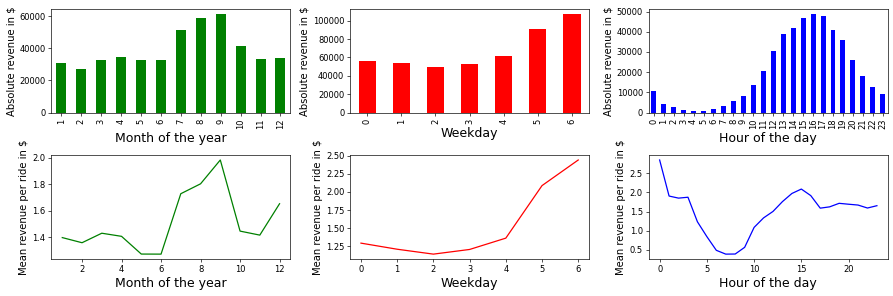

In [38]:
plt.subplots(figsize=(15,5), dpi= 60)
plt.subplot(2, 3, 1)
#plt.plot(month_sum, "g")
ax = month_sum.plot(kind = "bar", color = "g")
plt.xlabel('Month of the year', size = "15")
plt.ylabel("Absolute revenue in $", size = "12")

plt.subplot(2, 3, 4)
plt.plot(month_mean, "g")
plt.xlabel('Month of the year', size = "15")
plt.ylabel("Mean revenue per ride in $", size = "12")

plt.subplot(2, 3, 2)
#plt.plot(weekday_sum, "r")
ax = weekday_sum.plot(kind = "bar", color = "r")
plt.xlabel('Weekday', size = "15")
plt.ylabel("Absolute revenue in $", size = "12")

plt.subplot(2, 3, 5)
plt.plot(weekday_mean, "r")
plt.xlabel('Weekday', size = "15")
plt.ylabel("Mean revenue per ride in $", size = "12")

plt.subplot(2, 3, 3)
#plt.plot(hour_sum, "b")
ax = hour_sum.plot(kind = "bar", color = "b")
plt.xlabel('Hour of the day', size = "15")
plt.ylabel("Absolute revenue in $", size = "12")

plt.subplot(2, 3, 6)
plt.plot(hour_mean, "b")
plt.xlabel('Hour of the day', size = "15")
plt.ylabel("Mean revenue per ride in $", size = "12")

#plt.subplots_adjust(left=None, bottom=None, right=1, top=0.5, wspace=0.5, hspace=None)
plt.tight_layout()


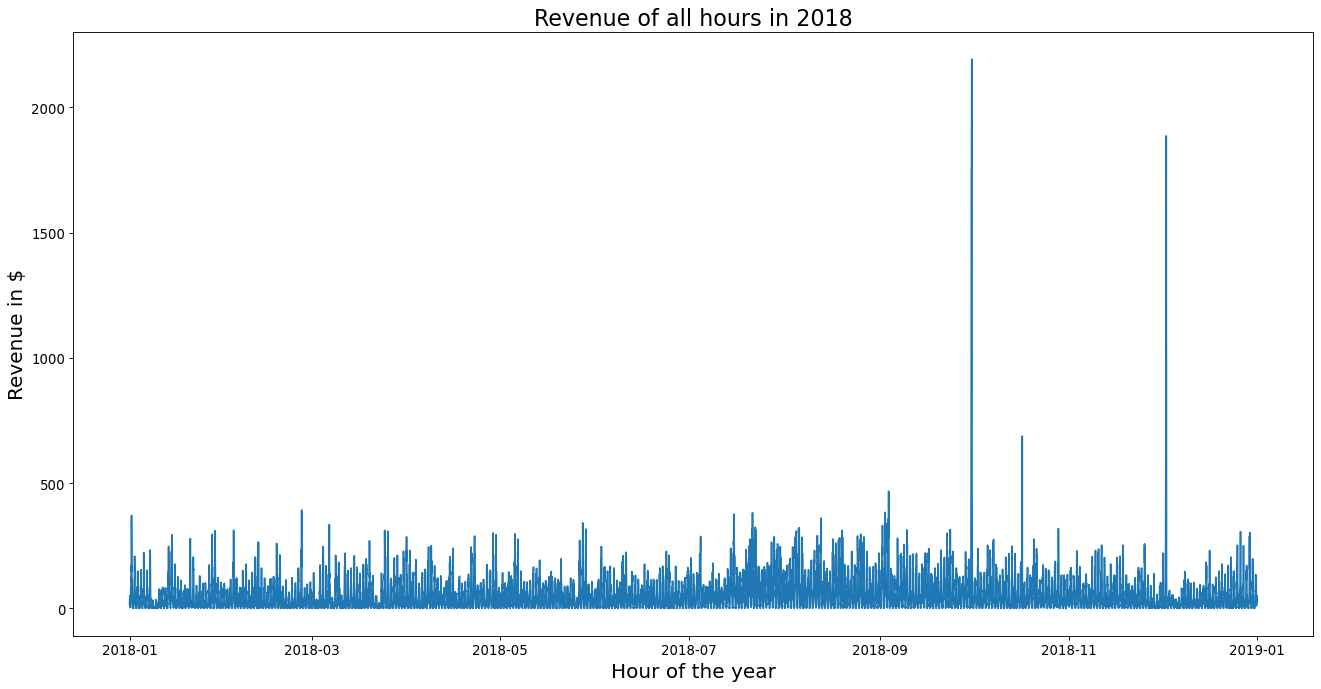

In [39]:
k = df_temp.copy()
k = k.set_index("end_time")
p = k.revenue.resample('H').sum()

fig,ax = plt.subplots(figsize=(20,10), dpi= 80)

ax.plot(p, color = 'tab:blue')
ax.set_title("Revenue of all hours in 2018", dic)
ax.set_ylabel('Revenue in $',**axis_font)
ax.set_xlabel('Hour of the year',**axis_font)
ax.tick_params(axis='both', **label_font)
plt.show()

#### Revenue per hour of the day

In [40]:
hour_sum

end_time_hour
0     10794.00
1      4126.50
2      2819.25
3      1408.75
4       728.00
5       831.25
6      1552.25
7      3437.00
8      5904.50
9      8228.50
10    13688.50
11    20553.75
12    30485.00
13    38641.75
14    41776.00
15    46669.00
16    48798.75
17    47673.50
18    40783.75
19    36135.75
20    26223.75
21    17997.00
22    12453.00
23     9068.50
Name: revenue, dtype: float64

In [41]:
hour_sum.describe()

count       24.000000
mean     19615.750000
std      17263.284891
min        728.000000
25%       3954.125000
50%      13070.750000
75%      36762.250000
max      48798.750000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Revenue per hour of the day')

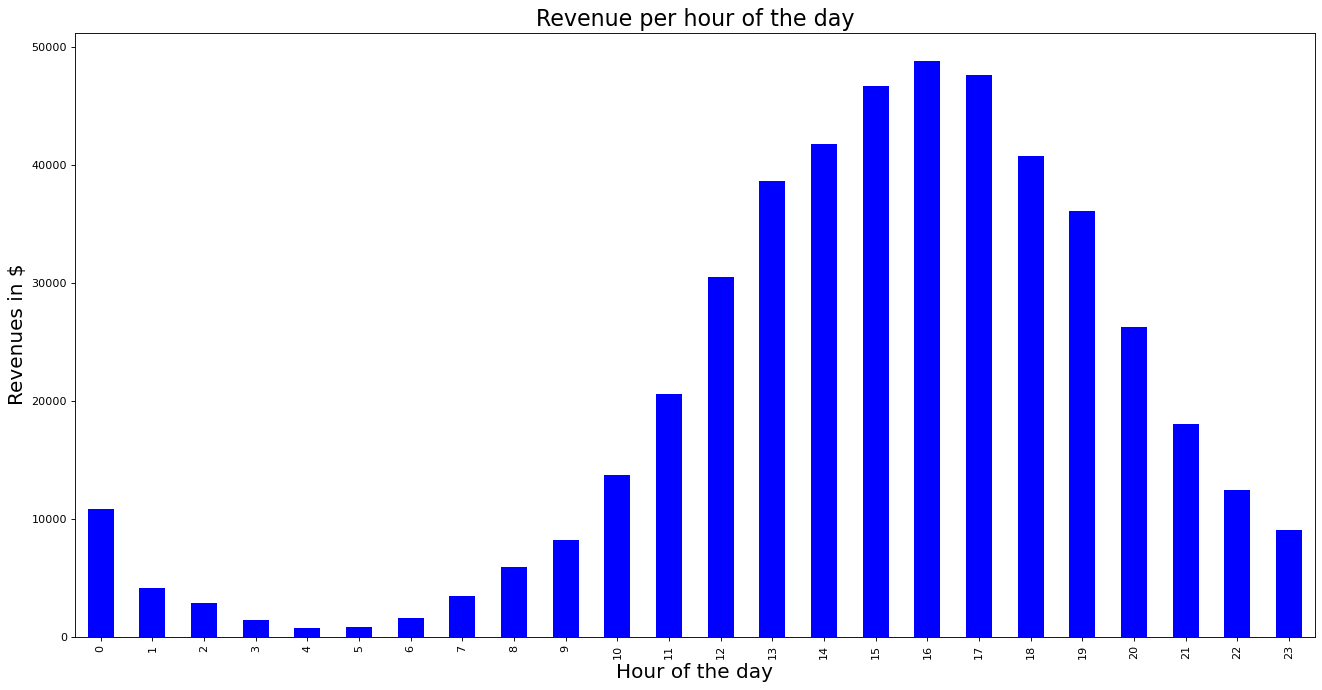

In [42]:
plt.subplots(figsize=(20,10), dpi= 80)
ax = hour_sum.plot(kind = "bar", color = "b")
plt.xlabel("Hour of the day", **axis_font)
plt.ylabel("Revenues in $", **axis_font)
plt.title("Revenue per hour of the day", dic)

In the 17th hour of the day the most revenues were generated (time between 16:00 and 17:00). In General most of the revenue was generated between 12:00 and 20:00.

#### Revenue per weekday

In [43]:
weekday_sum

end_time_weekday
0     55795.25
1     53851.00
2     49101.50
3     52393.25
4     61484.50
5     90774.25
6    107378.25
Name: revenue, dtype: float64

In [44]:
weekday_sum.describe()

count         7.000000
mean      67254.000000
std       22574.850445
min       49101.500000
25%       53122.125000
50%       55795.250000
75%       76129.375000
max      107378.250000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Revenue per weekday')

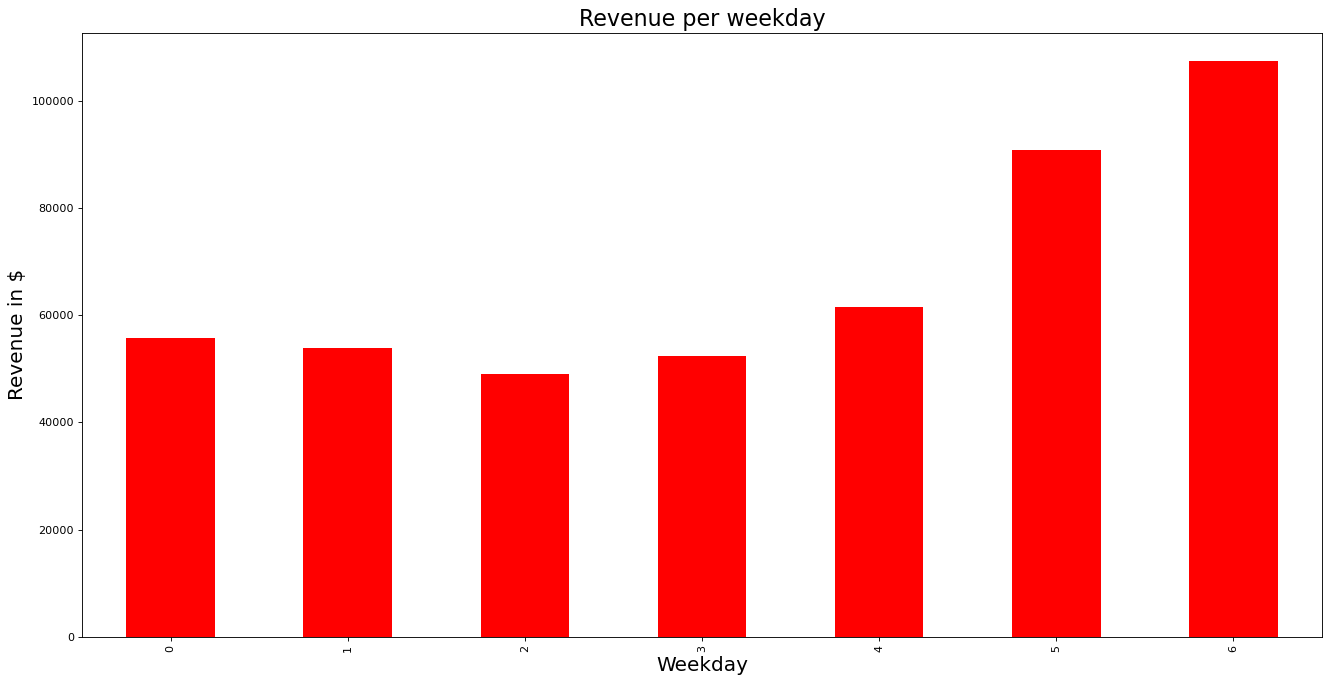

In [45]:
plt.subplots(figsize=(20,10), dpi= 80)
ax = weekday_sum.plot(kind = "bar", color = "r")
#plt.plot(weekday_sum)
plt.xlabel('Weekday', **axis_font)
plt.ylabel("Revenue in $", **axis_font)
plt.title("Revenue per weekday", dic)

The most revenue was generated on sundays. In general weekend performed better than working days.

Text(0.5, 1.0, 'Mean Revenue per ride per weekday')

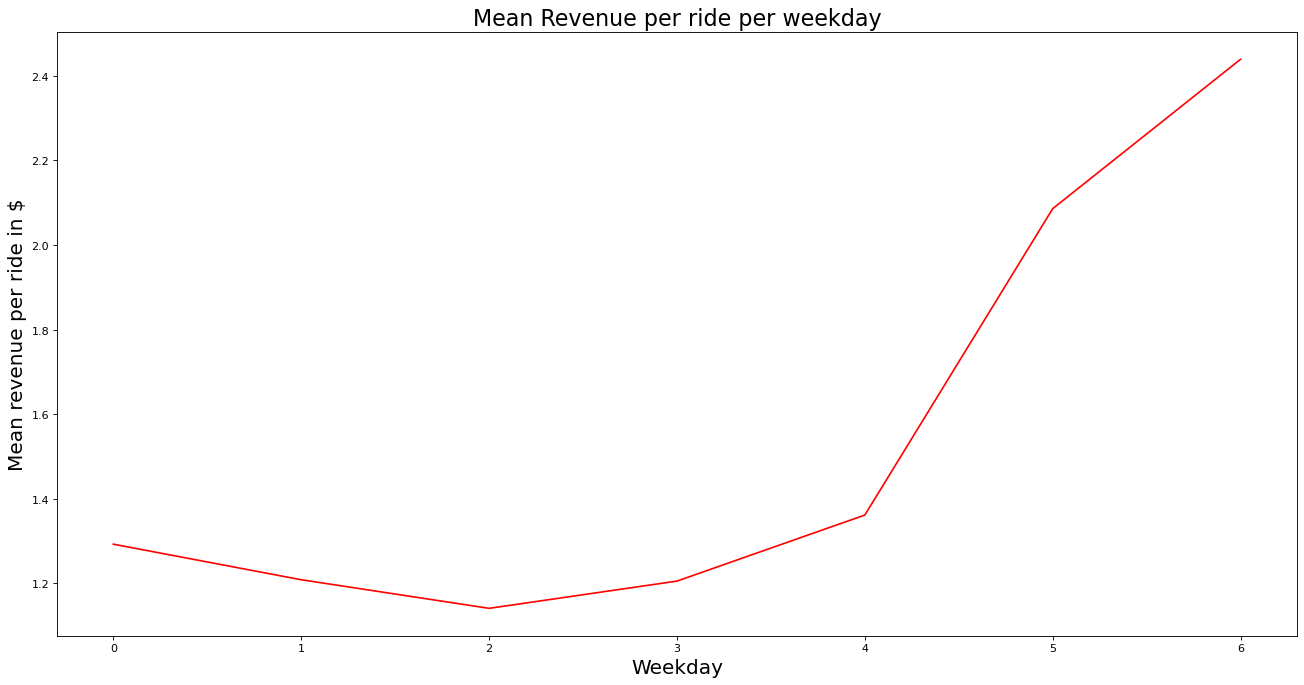

In [46]:
plt.subplots(figsize=(20,10), dpi= 80)
ax = weekday_mean.plot(color = "r")
#plt.plot(weekday_sum)
plt.xlabel('Weekday', **axis_font)
plt.ylabel("Mean revenue per ride in $", **axis_font)
plt.title("Mean Revenue per ride per weekday", dic)

Weekends produce more revenue also because the revenues per ride are significantly higher than on working days.

#### Revenue per month

In [47]:
month_sum

end_time_month
1     30609.25
2     26822.25
3     32695.25
4     34599.25
5     32819.50
6     32996.25
7     51497.25
8     58677.50
9     61355.00
10    41217.75
11    33372.50
12    34116.25
Name: revenue, dtype: float64

In [48]:
month_sum.describe()

count       12.0000
mean     39231.5000
std      11500.9435
min      26822.2500
25%      32788.4375
50%      33744.3750
75%      43787.6250
max      61355.0000
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Revenue per month')

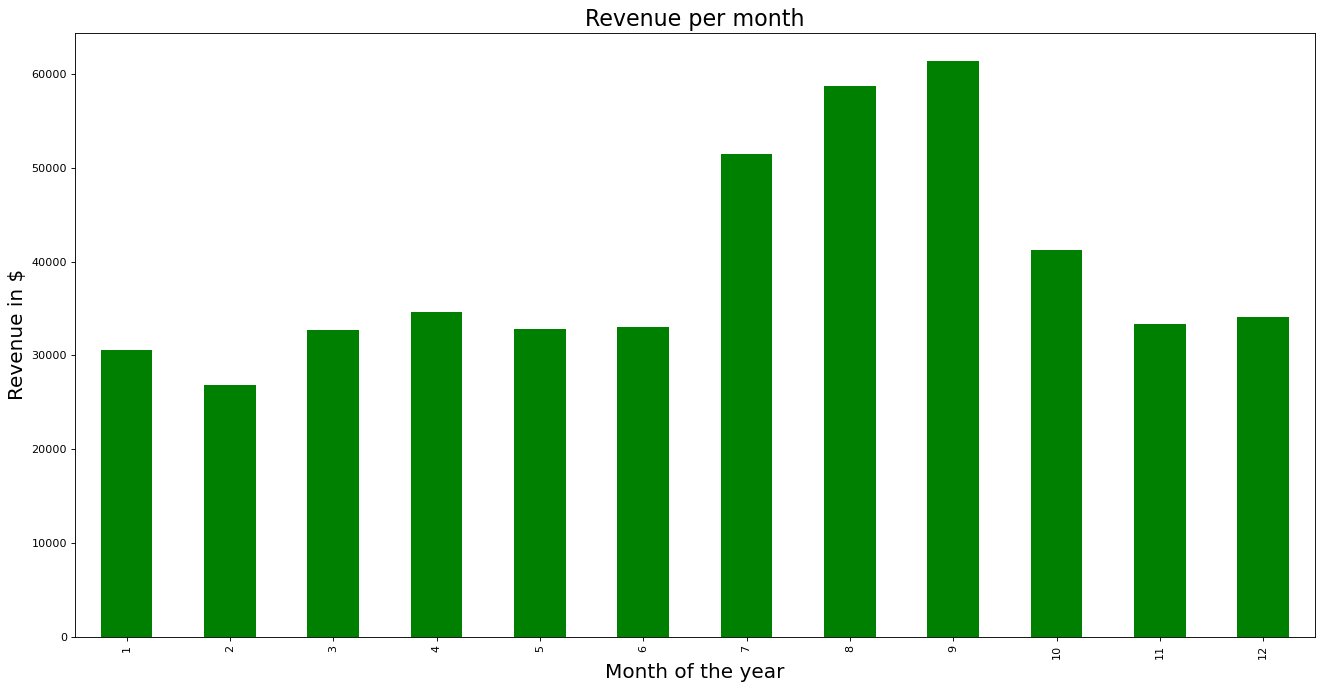

In [49]:
plt.subplots(figsize=(20,10), dpi= 80)
ax = month_sum.plot(kind = "bar", color = "g")
plt.xlabel('Month of the year', **axis_font)
plt.ylabel("Revenue in $", **axis_font)
plt.title("Revenue per month", dic)

The most revenue was generated in September in which 61355$ were earned. In general the summer months generated more revenue.

Text(0.5, 1.0, 'Mean revenue per ride per month')

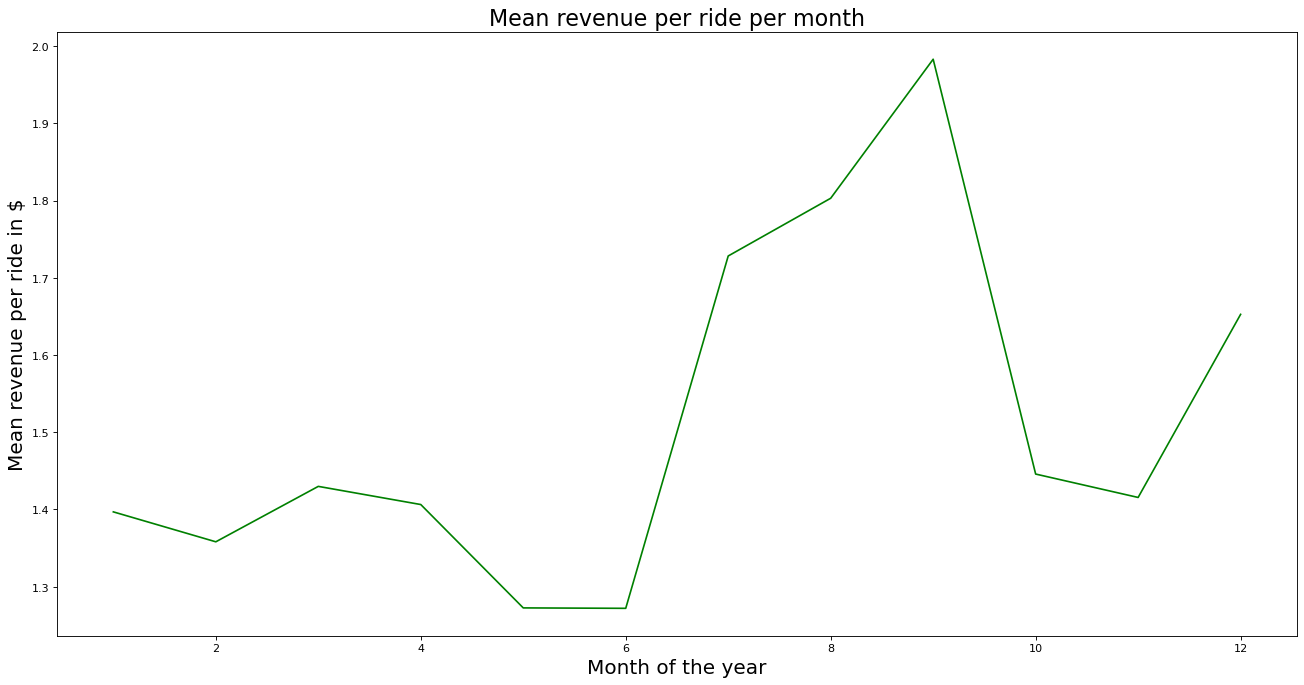

In [50]:
plt.subplots(figsize=(20,10), dpi= 80)
plt.plot(month_mean, color = "g")
plt.xlabel('Month of the year', **axis_font)
plt.ylabel("Mean revenue per ride in $", **axis_font)
plt.title("Mean revenue per ride per month", dic)

We can see, that the more generated revenue in the summer months is not only because of more rides, but also because the rides on average generated more profits. People seem to like riding longer in the summer months.

#### Revenue for Week/Weekday

Text(0, 0.5, 'Mean revenue per ride in $')

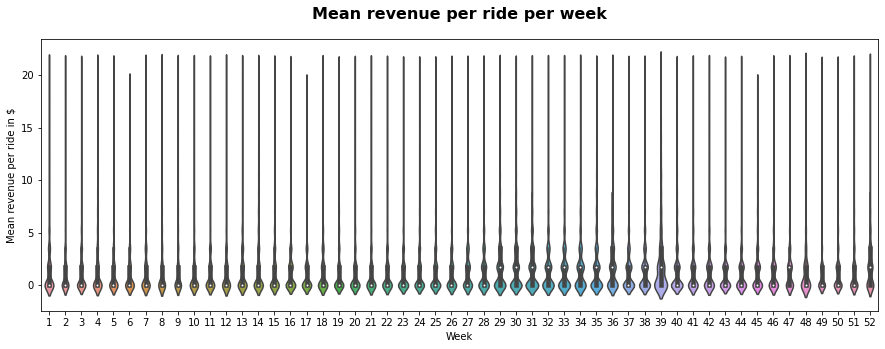

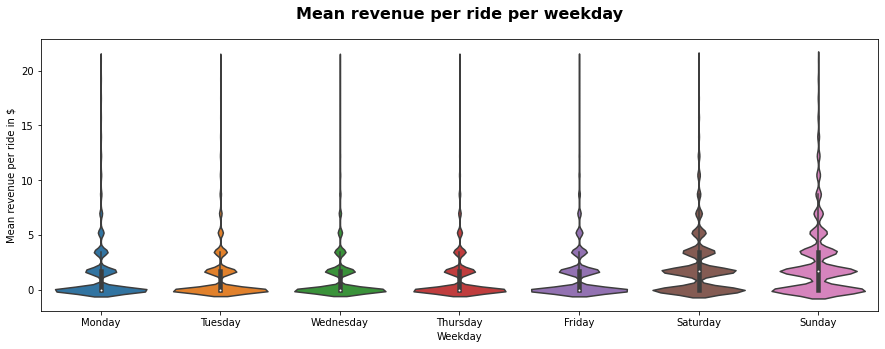

In [51]:
######WEEK########
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(
    x=df_temp['end_time_week'],
    y=df_temp['revenue'],
    scale="count")

ax.set_title("Mean revenue per ride per week", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel('Week')
ax.set_ylabel("Mean revenue per ride in $")


######WEEKday########
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(
    x=df_temp['end_time_weekday'],
    y=df_temp['revenue'],
    scale="count")

ax.set_title("Mean revenue per ride per weekday", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel('Weekday')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel("Mean revenue per ride in $")


#### Revenue for different user_types

As already mentioned we don't have any user data. But we are able to see how much revenue (without pass prices) was generated by which user_types.

In [52]:
user_type_sum = df_temp.groupby("user_type")["revenue"].sum()
user_type_sum

user_type
Annual Pass        225.75
Flex Pass         1550.50
Monthly Pass     25823.00
One Day Pass     38288.25
Walk-up         404890.50
Name: revenue, dtype: float64

Text(0.5, 1.0, 'Revenue for each User_Type')

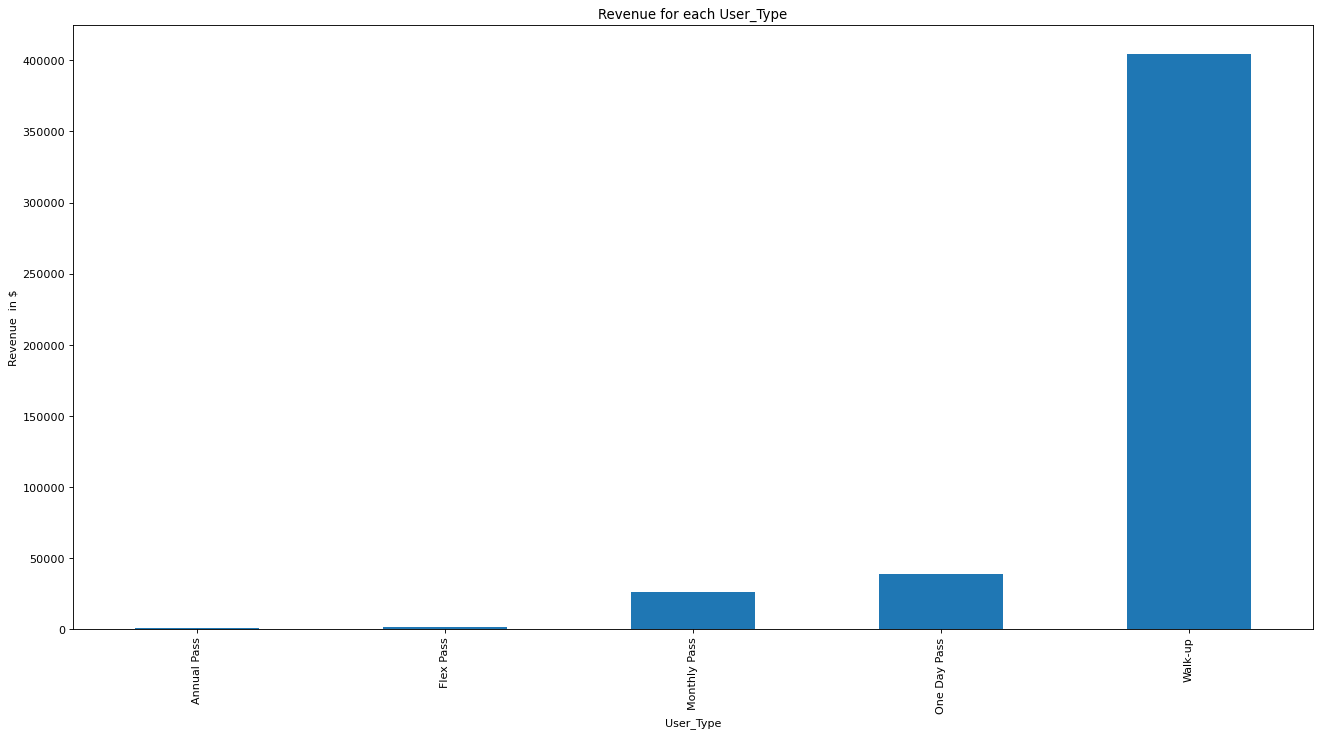

In [53]:
plt.subplots(figsize=(20,10), dpi= 80)
ax = user_type_sum.plot(kind = "bar")
plt.xlabel('User_Type')
plt.ylabel("Revenue  in $")
plt.title("Revenue for each User_Type")

Here, of course, it is very clear that for a correct calculation of the revenue, the sales figures for the passes are needed. All rides of people with a pass that are under 30 minutes generate no revenue with our method.

#### Revenue for different stations

In [54]:
end_station_sum = df_temp.groupby("end_station_name")["revenue"].sum()
start_station_sum = df_temp.groupby("start_station_name")["revenue"].sum()
id_end_station_sum = df_temp.groupby("end_station_id")["revenue"].sum()
id_start_station_sum = df_temp.groupby("start_station_id")["revenue"].sum()
tempHead = ((id_end_station_sum + id_start_station_sum)/2).sort_values(ascending=False).head(5).index
tempTail = ((id_end_station_sum + id_start_station_sum)/2).sort_values().head(5).index

In [55]:
((end_station_sum + start_station_sum)/2).describe()

count      132.000000
mean      3566.500000
std       7492.573222
min         42.000000
25%        640.281250
50%       1660.750000
75%       3602.156250
max      56675.500000
Name: revenue, dtype: float64

In [56]:
((end_station_sum + start_station_sum)/2).sort_values()

end_station_name
4108                                       42.000
Expo Park/LAFC                             52.500
28th & Figueroa                            52.500
Banning's Landing                          80.500
San Julian & 12th                         164.500
                                          ...    
Windward & Main                         13131.125
Pacific & North Venice                  13730.500
Ocean Front Walk & North Venice         45036.250
Downtown Santa Monica E Line Station    45612.000
Ocean Front Walk & Navy                 56675.500
Name: revenue, Length: 132, dtype: float64

The station that accounted for the most revenue was "Ocean Front Walk & Navy". This was calculated by attributing half of a rides revenues to the start_station and the other half to the end_station. The station that generated the least revenue was "4108". 

The following map visualizes the locations of the stations with the five highest (red) and lowest (blue) cumulated revenues.

In [57]:
# define new map function
def getLocation(top_station_id, least_station_id):
    getLocation = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add station point map
    for station in top_station_id:
        geo = df_LA_stations.coord[df_LA_stations['station_id'] == station].values[0]
        #print(geo)
        folium.CircleMarker(
            radius=5,
            location=geo,
            popup='Station ID: '+ str(station), 
            color='crimson', 
            alpha=0.2,
            fill_color='crimson'
        ).add_to(getLocation)
    for station in least_station_id:
        geo = df_LA_stations.coord[df_LA_stations['station_id'] == station].values[0]
        #print(geo)
        folium.CircleMarker(
            radius=5,
            location=geo,
            popup='Station ID: '+ str(station), 
            color='blue', 
            alpha=0.2,
            fill_color='blue'
        ).add_to(getLocation)
    return getLocation

#top 5 stations
map4 = getLocation(list(tempHead), list(tempTail))
map4

In the map above, we can see that the top five stations that generate the 
highest revenue (red) are all located in Santa Monica. The five stations with 
the lowest revenues (blue) are located in Los Angeles Center and in San Pedro respectively the southern harbor region.

## Coverage

Regarding the indicator in the area of coverage, we thought of showing the geographical coverage of the stations in the region of LA. For that we are using a heatmap. The closer the bike stations are to each other, the warmer the colors in the heat map. Downtown LA shows the most dense coverage.

In [58]:
def heat_map(df, station_id):
    # define new map
    heat_map = folium.Map(
        location=center, 
        tiles='OpenStreetMap', 
        zoom_start=11, 
        control_scale=True, 
        max_zoom=20)
    # add heat map
    heat_map.add_child(
        plugins.HeatMap(df['coord'], radius=20))
    #heat map for destination points looks pretty much identical
    return heat_map
map5 = heat_map(df_LA_stations, np.array(df_LA_stations['station_id']))
map5

Comparing the coverage of the individual regions, it is noticeable that 
Los Angeles Center has the smallest distances between the individual stations. In the two coastal regions, on the other hand, the distances are greatest. 